In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint

In [2]:
%load_ext autoreload
%autoreload 1
%aimport main
%aimport data_utils
%aimport contrastive_data
%aimport models

In [3]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *

# Data and model

In [41]:
data_path = '/home/lguirardel/data/perturb_comp/data/TP53/'


In [42]:
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=True)

	Reading files...
		Reading matrix


		Reading genes and cells
		Reading variant data
	Merging and processing...
		Grouping WT-like variants.
		75 variant classes


Run from here to re-split without reloading all data (will be necessary if wtlike is changed however)

In [43]:
run_name = 'TP53_posneg_2'
dir_name = join('models',run_name)
! cat models/{run_name}/config.ini

alpha = 0.0
weight-decay = 0.01
batch-size = 256
positive-fraction = 0.2
n-epochs = 500
shape = [40, 40]
embed-dim = 20
loss = standard
margin = 1
dropout = 0.2
lr = 0.001
n-workers = 4


In [44]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, )
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

In [45]:
dl_train, dl_seen, dl_unseen = make_loaders(
    df_train, df_seen,df_unseen, batch_size=64, dataset_class=SiameseDataset,n_workers=1,pos_frac=0.5)

In [46]:
# model = torch.load(join(dir_name,'model.pkl'), map_location='cpu')
model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')

In [47]:
model

Siamese(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=1224, out_features=40, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=40, out_features=40, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=40, out_features=20, bias=True)
    )
  )
)

# PCA

In [48]:
X = torch.tensor(df_train.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))
embeds = torch.stack(embeds)
pca = PCA(2).fit(embeds)


# Embedding distribution

In [49]:
make_dir_if_needed(f'plots/embeds/{run_name}')

In [50]:
subset = 'test_seen'
df = df_seen

X = torch.tensor(df.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))
embeds = torch.stack(embeds)

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

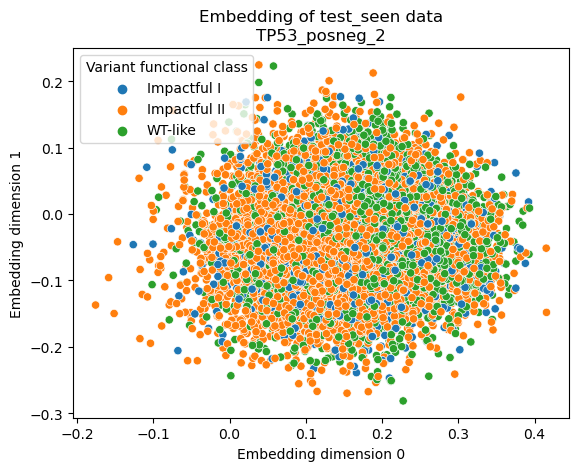

In [51]:
i,j = 0,1
sns.scatterplot(x=embeds[:,i], y=embeds[:,j], hue = df['Variant functional class'])
plt.xlabel(f'Embedding dimension {i}')
plt.ylabel(f'Embedding dimension {j}')
plt.title(f'Embedding of {subset} data\n{run_name}')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_{i}_{j}_scatter.pdf')

In [52]:
# sns.kdeplot(x=embeds[:,i], y=embeds[:,j], hue = df['Variant functional class'], levels=5, common_norm=False)
# plt.xlabel(f'Embedding dimension {i}')
# plt.ylabel(f'Embedding dimension {j}')
# plt.title(f'{subset} data embedding distribution\n{run_name}')
# plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_{i}_{j}_kde.pdf')

In [60]:
print(f'Explained variance : {(pca.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 53.0 %


Explained variance : 53.0 %


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

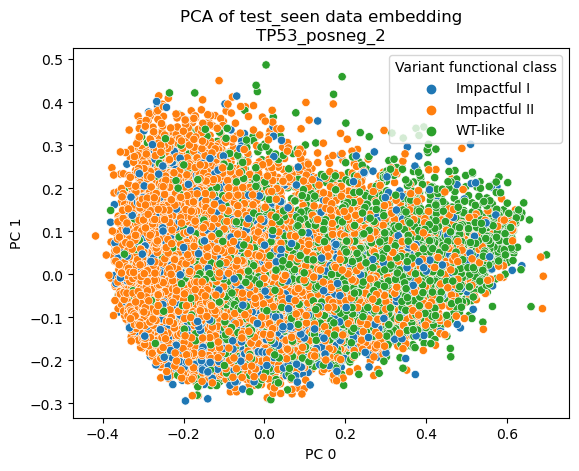

In [53]:
emb_red = pca.transform(embeds)
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'])
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding\n{run_name}')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_scatter.pdf')

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

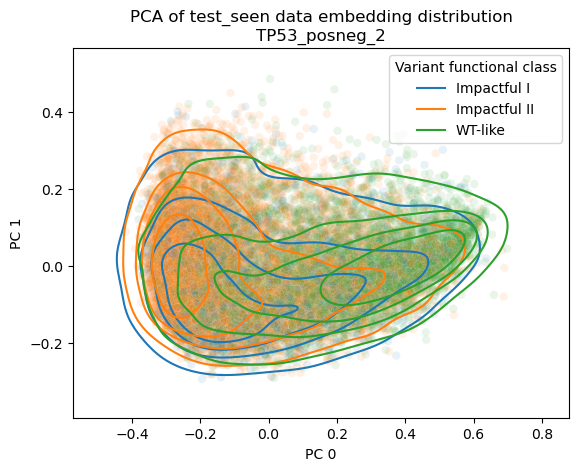

In [54]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], alpha=0.1, legend=False)
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], levels=5, common_norm=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_kde.pdf')

In [55]:
df[df['Variant functional class'] == 'Impactful I'].variant.unique()

array(['unassigned', 'R273C', 'R213Q', 'R273H', 'R280K', 'C277F', 'M237I',
       'R337L', 'K132R', 'R273L', 'P152L'], dtype=object)

In [56]:
# variants = ['R110L', 'G245D', 'R213Q','R158H']


# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], levels=5, common_norm=False, legend=False,palette='gray')
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# for v in variants:
#     idx = (df['variant'] == v).to_numpy()
#     plt.scatter(x=emb_red[idx,0], y=emb_red[idx,1],label=v, marker='x',alpha=0.5)
# plt.legend()

# Scores

## Intra-group

In [57]:
subset = 'train'
group = 'Impactful II'
df = df_train

df = df[df['Variant functional class'] == group]

X = torch.tensor(df.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))
embeds = torch.stack(embeds)

emb_red = pca.transform(embeds)


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

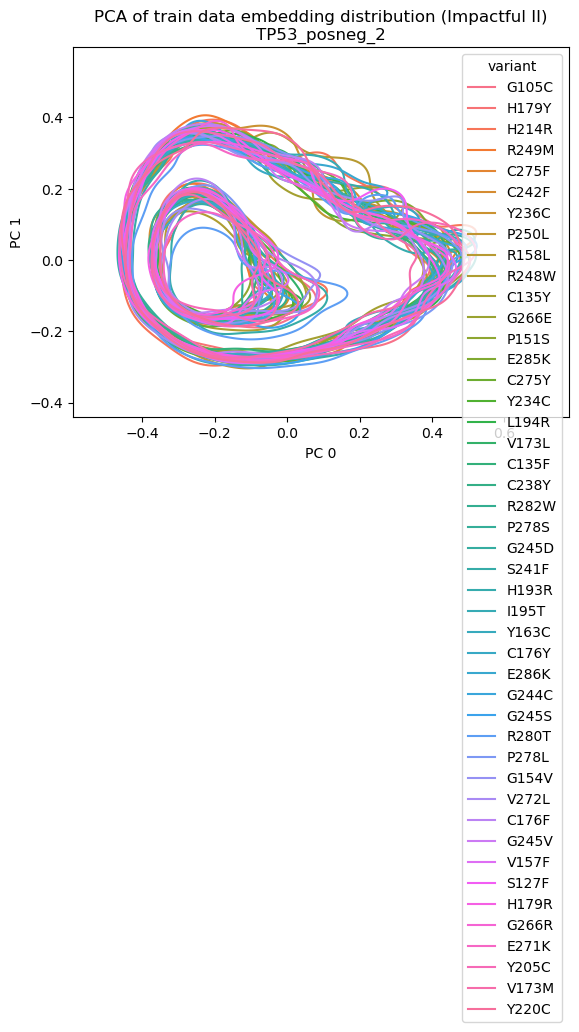

In [58]:
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['variant'], levels=3, common_norm=False)
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} data embedding distribution ({group})\n{run_name}' )
# plt.savefig(f'plots/embeds/{run_name}/{subset}_{group}_embed_pca_kde.pdf')

In [59]:
dl = DataLoader(SiameseDataset(df, p=0.5), batch_size=64, shuffle=True)
metrics = test_loop(dl, model, SiameseLoss(margin=1, alpha=0), margin=1)
print(f'Metrics for {subset} data, {group=}')
pprint(metrics)

TypeError: test_loop() missing 1 required positional argument: 'device'

## Inter-group

En chantier - je pense que ça fait plus de sens avec une metrique 1-nn que avec la ROC 

In [ ]:
subset = 'train'
group1 = 'Impactful I'
group2 = 'Impactful II'
df = df_train

df1 = df[df['Variant functional class'] == group1]
df2 = df[df['Variant functional class'] == group2]


In [ ]:
dl = DataLoader(
    BipartiteDataset(df1, df2, p1=0.5), # will always get 
    batch_size=64, shuffle=True,
)

In [ ]:
metrics = test_loop(dl, model, SiameseLoss(margin=1, alpha=0), device='cpu', margin=1)
print(f'Metrics for {subset} data, {group1=}, {group2=}')
pprint(metrics)

Metrics for train data, group1='Impactful I', group2='Impactful II'
{'_n_neg': 3410,
 '_n_pos': 3353,
 'dist_neg': 1.4901349544525146,
 'dist_pos': 0.20445066690444946,
 'l2_penalty': 0.0,
 'loss': 0.06948248616788748,
 'roc': 0.9615837931632996}


# Training

In [61]:
from tensorboard.backend.event_processing import event_accumulator

In [62]:
ea = event_accumulator.EventAccumulator(f'runs/{run_name}')

## Checking score

In [63]:
metrics = test_loop(dl_seen, model, SiameseLoss(margin=1, alpha=0),  margin=1, device='cpu')
pprint(metrics)

{'_n_neg': 8488,
 '_n_pos': 8431,
 'dist_neg': 0.5398533940315247,
 'dist_pos': 0.508025050163269,
 'l2_penalty': 0.0,
 'loss': 0.2570896842007367,
 'roc': 0.5563380718231201}


## Plotting training curves

In [64]:
make_dir_if_needed('plots/runs')

In [65]:
ea.Reload()

In [66]:
ea.scalars.Keys()

['train/dist_pos',
 'train/dist_neg',
 'train/l2_penalty',
 'train/loss',
 'train/roc',
 'test_seen/dist_pos',
 'test_seen/dist_neg',
 'test_seen/l2_penalty',
 'test_seen/loss',
 'test_seen/roc',
 'test_unseen/dist_pos',
 'test_unseen/dist_neg',
 'test_unseen/l2_penalty',
 'test_unseen/loss',
 'test_unseen/roc']

In [67]:
# def get_df_from_tb(ea:event_accumulator.EventAccumulator, keys:List[str]=None) :
#     df = pd.DataFrame()
#     if keys is None:
#         keys = ea.scalars.Keys()
#     for key in keys:
#         events = ea.scalars.Items(key)
#         df[key] = pd.Series(data=[e.value for e in events], index=[e.step for e in events])
#     return df

In [68]:
def get_df_from_tb(ea:event_accumulator.EventAccumulator, keys:List[str]=None) :
    df = []
    if keys is None:
        keys = ea.scalars.Keys()
    for key in keys:
        events = ea.scalars.Items(key)
        for e in events:
            data_set, variable = key.split('/')

            df.append({'data set':data_set, 'variable':variable, 'epoch':e.step,'value':e.value})
    return pd.DataFrame.from_records(df)

In [69]:
df = get_df_from_tb(ea,)

In [70]:
df

,data set,variable,epoch,value
0,train,dist_pos,0,0.805950
1,train,dist_pos,0,0.808496
2,train,dist_pos,1,0.783317
3,train,dist_pos,2,0.784267
4,train,dist_pos,3,0.782051
...,...,...,...,...
4790,test_unseen,roc,314,0.499254
4791,test_unseen,roc,315,0.508508
4792,test_unseen,roc,316,0.500696
4793,test_unseen,roc,317,0.514196


In [71]:
df = df[(df['data set']!='test_unseen')]

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

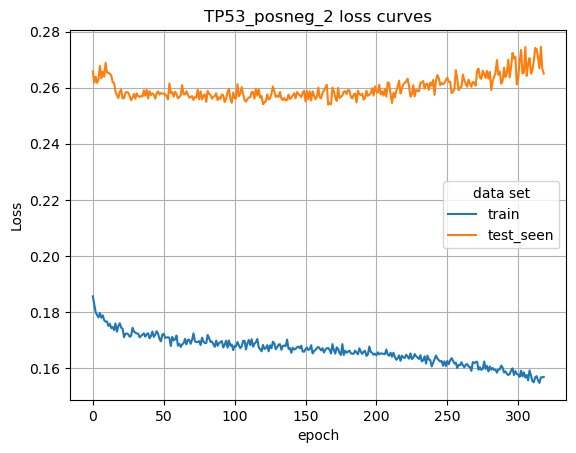

In [72]:
sns.lineplot(df[(df.variable == 'loss')], x='epoch',y='value',hue='data set')
plt.title(f'{run_name} loss curves')
plt.ylabel('Loss')
# plt.yscale('logit')
plt.savefig(f'plots/runs/{run_name}_loss.pdf')
plt.grid()


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

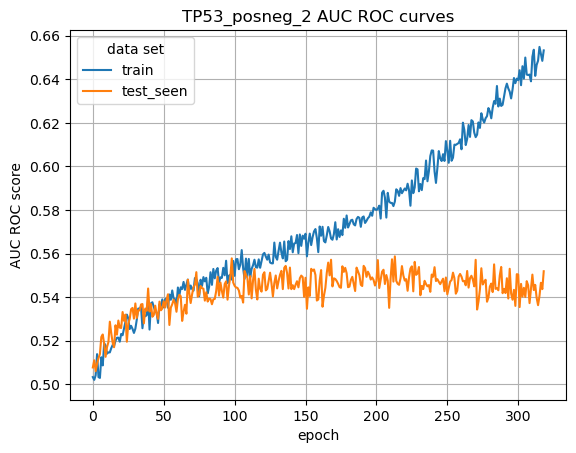

In [73]:
sns.lineplot(df[df.variable == 'roc'], x='epoch',y='value',hue='data set')
plt.title(f'{run_name} AUC ROC curves')
plt.ylabel('AUC ROC score')
# plt.yscale('logit')
plt.savefig(f'plots/runs/{run_name}_roc.pdf')
plt.grid()


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

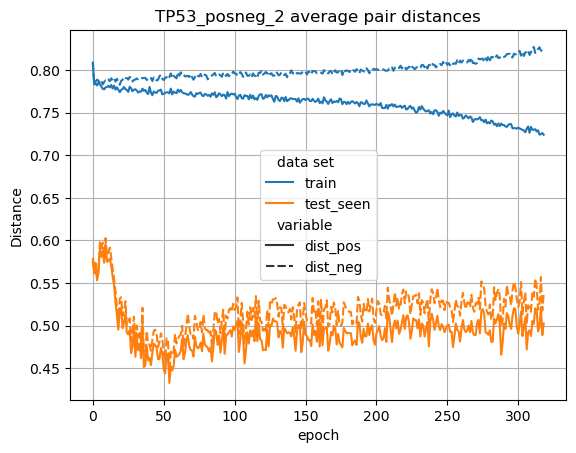

In [74]:
sns.lineplot(df[df.variable.str.startswith('dist')], x='epoch',y='value',hue='data set', style='variable')
plt.title(f'{run_name} average pair distances')
plt.ylabel('Distance')
# plt.yscale('logit')
plt.savefig(f'plots/runs/{run_name}_dist.pdf')
plt.grid()
